In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP_v2
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

from bcnf.train.trainer_data_handler import TrainerDataHandler
from bcnf.train.utils import get_data_type

## Model

In [3]:
MODEL_NAME = f'videos_double_CNN_LSTM_large'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])

cnf = CondRealNVP_v2.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

Example camera input size: torch.Size([1, 1, 90, 160])
Output size after first layer: torch.Size([1, 5, 45, 80])
Output size after layer 1: torch.Size([1, 10, 22, 40])
Output size after layer 2: torch.Size([1, 15, 10, 19])
Final output size: 5700
ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.25, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)


In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 57,355,414


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')
data_keys = data.keys()
data_keys = {key: key for key in data_keys}

del data
print(data_keys)

Loading data from directory:   0%|          | 0/1 [00:00<?, ?it/s, file=fixed_data_render_2s_15FPS_5.pkl]

Loading data from directory: 100%|██████████| 1/1 [00:08<00:00,  8.40s/it, file=fixed_data_render_2s_15FPS_5.pkl]


{'x0_x': 'x0_x', 'x0_y': 'x0_y', 'x0_z': 'x0_z', 'v0_x': 'v0_x', 'v0_y': 'v0_y', 'v0_z': 'v0_z', 'g': 'g', 'w_x': 'w_x', 'w_y': 'w_y', 'w_z': 'w_z', 'b': 'b', 'A': 'A', 'Cd': 'Cd', 'rho': 'rho', 'm': 'm', 'a_x': 'a_x', 'a_y': 'a_y', 'a_z': 'a_z', 'cam_radian': 'cam_radian', 'r': 'r', 'cam_radius': 'cam_radius', 'cam_angles': 'cam_angles', 'cam_heights': 'cam_heights', 'trajectories': 'trajectories'}


In [9]:
y, conditions = TrainerDataHandler().get_data_for_training(
    config,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    return_tensor_dataset=False)

print(f'{y.shape=}')
for condition in conditions:
    print(f'{condition.shape=}')

y.shape=torch.Size([1000, 19])
condition.shape=torch.Size([1000, 2, 30, 90, 160])
condition.shape=torch.Size([1000, 7])


## Resimulation

In [10]:
data_keys['g_z'] = data_keys.pop('g')
data_keys['g_x'] = np.zeros_like(data_keys['g_z'])
data_keys['g_y'] = np.zeros_like(data_keys['g_z'])

In [12]:
# https://github.com/scipy/scipy/issues/15940
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=dt,
    y_hat=None,
    data_dict=data_keys,
    conditions=conditions,
    m_samples=1_00, # Number of samples to draw from the model per simulation sample
    batch_size=2,  # has to be smaller than m_samples
    break_on_impact=True
)

Batch Sampling: 100%|██████████| 500/500 [03:20<00:00,  2.49it/s]


Resimulating 1000 trajectories 100 times


Resimulating trajectories:   0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
X_resimulation.shape

(100, 1000, 30, 3)

In [ ]:
X_trajectories.shape

(1000, 30, 3)

## Resimulation Error

In [ ]:
X_error = (X_resimulation - X_trajectories[None, :, :, :])**2
X_error_copy = X_error.copy()
print(f'{X_error.shape=}')

X_error.shape=(100, 1000, 30, 3)


In [ ]:
X_errors = np.nanmedian(X_error, axis=(1, 3))

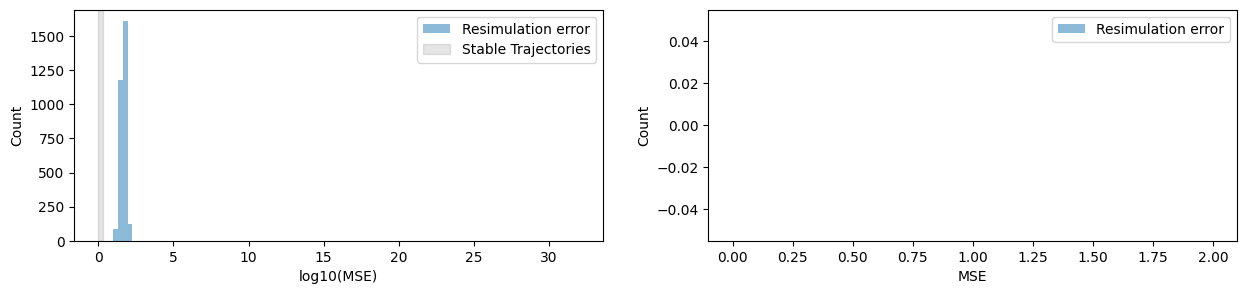

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

zoom_until = 2

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(zoom_until), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, zoom_until, 100), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

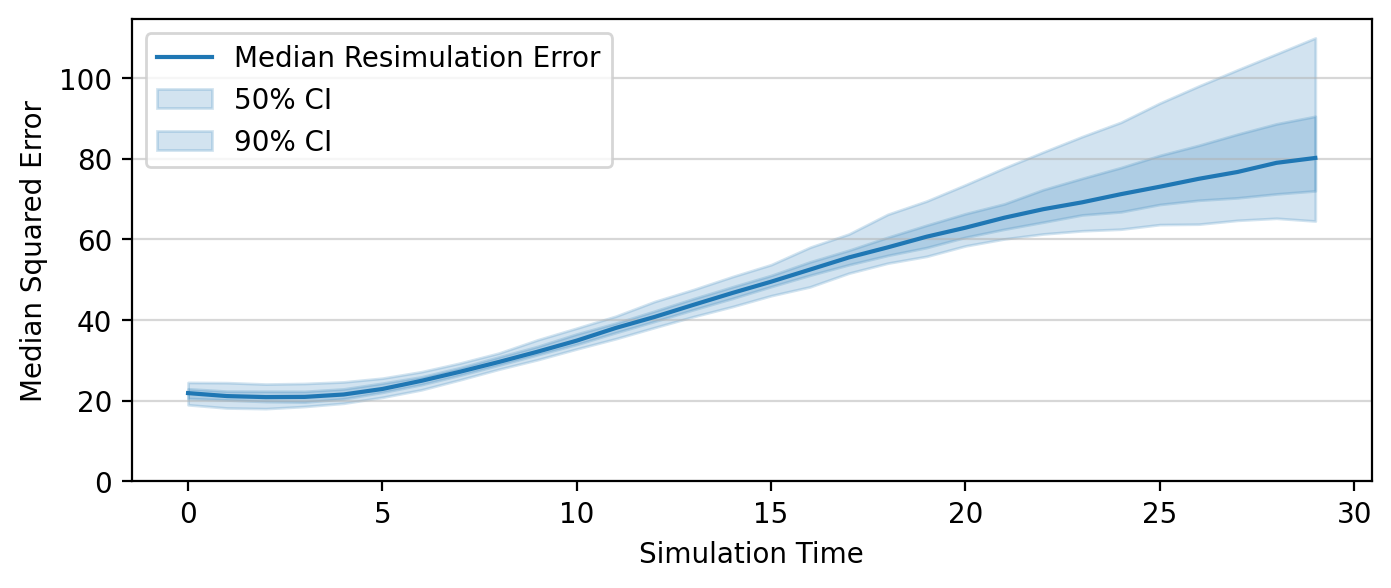

In [ ]:
# Show the median resimulation error over simulation time
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=200)

ax.plot(np.nanmedian(X_errors, axis=0), label='Median Resimulation Error')
ax.fill_between(np.arange(STEPS), *np.nanpercentile(X_errors, [25, 75], axis=0), alpha=0.2, color='C0', label='50% CI')
ax.fill_between(np.arange(STEPS), *np.nanpercentile(X_errors, [5, 95], axis=0), alpha=0.2, color='C0', label='90% CI')
ax.set_ylim(0, None)

ax.set_xlabel('Simulation Time')
ax.set_ylabel('Median Squared Error')
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_error.png'), bbox_inches='tight')

## Impact

In [ ]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [ ]:
true_impact_indices = np.where(np.diff((X_trajectories[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X_trajectories[true_impact_indices[0], true_impact_indices[1]]

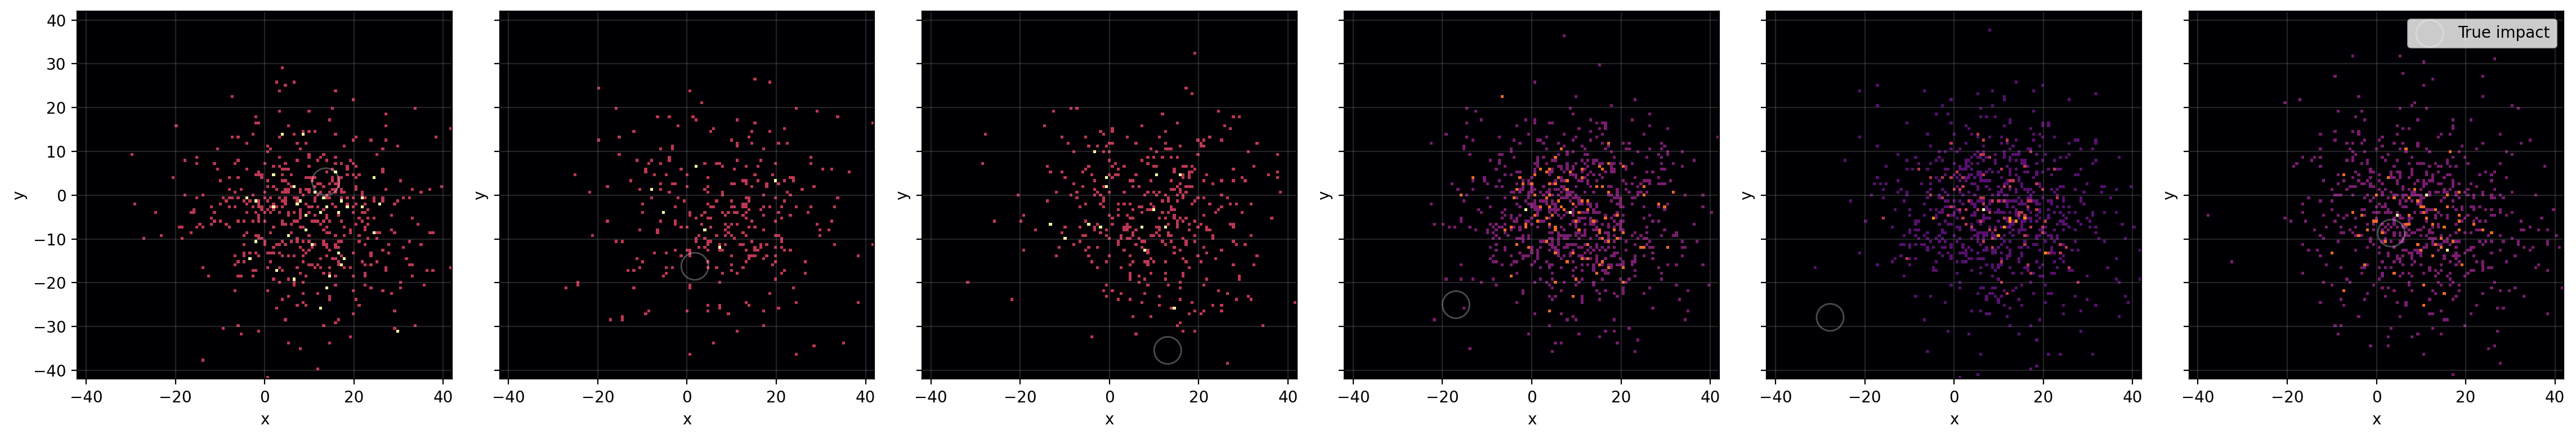

In [ ]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, axes = plt.subplots(1, 6, figsize=(23, 4), sharey=True, dpi=200)

for i, (show_index, ax) in enumerate(zip(true_impact_indices[0], axes)):
    X_val_impact_position = X_trajectories[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :]

    ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-42, 42, 128), cmap='inferno');
    ax.scatter(X_val_impact_position[0], X_val_impact_position[1], s=300, marker='o', label='True impact', facecolors='none', edgecolors='white', alpha=0.3);
    ax.grid(axis='both', alpha=0.2);
    ax.set_xlabel('x');
    ax.set_ylabel('y');

ax.legend();

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_impact_heatmap.png'))

## Resimulations

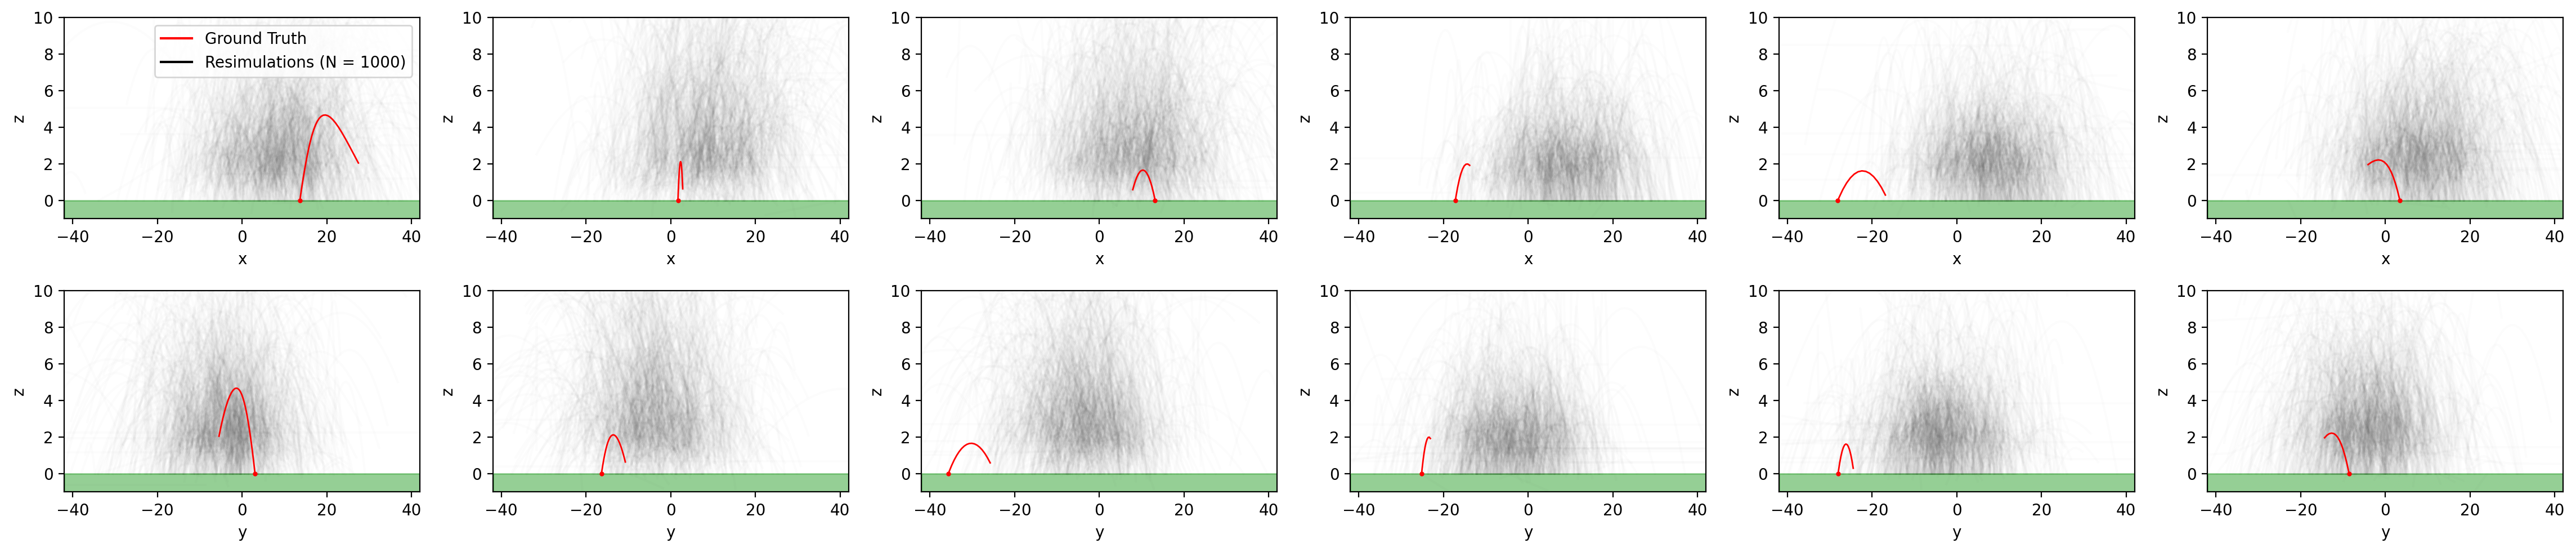

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(23, 5), dpi=200)

n_trajectories = 1000
max_time = 1000

for i, (ax_row, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    for show_index, ax in zip(true_impact_indices[0], ax_row):
        ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
        ax.plot(X_trajectories[show_index, :, i], X_trajectories[show_index, :, 2], label='Ground Truth', color='red', linewidth=1);
        ax.plot(X_trajectories[show_index, -1, i], X_trajectories[show_index, -1, 2], marker='o', markersize=2, color='red');
        ax.set_xlim(-42, 42)
        ax.set_ylim(-1, 10)
        ax.set_xlabel(ax_name);
        ax.set_ylabel('z');
        ax.axhspan(-2, 0, alpha=0.5, color='tab:green');


# Add an additional legend for resimulation with red and black lines
red_patch = plt.Line2D([0], [0], color='red', label='Ground Truth')
black_patch = plt.Line2D([0], [0], color='black', label=f'Resimulations (N = {n_trajectories})')
axes[0, 0].legend(handles=[red_patch, black_patch], loc='upper right');

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation.png'), dpi=200)

## Calcualate model score

### Trajectory

In [ ]:
X_error_copy_perm = X_error_copy.transpose(1, 0, 2, 3)
print(f'{X_error_copy_perm.shape=}')

X_error_copy_perm.shape=(1000, 100, 30, 3)


In [ ]:
error_traj = np.median(X_error_copy_perm, axis=(1, 2, 3))
print(f'{error_traj.shape=}')

error_traj.shape=(1000,)


Number of elements in error_traj:  1000 Number of elements in error_traj_mod:  1000
Mean trajectory error:  44.945


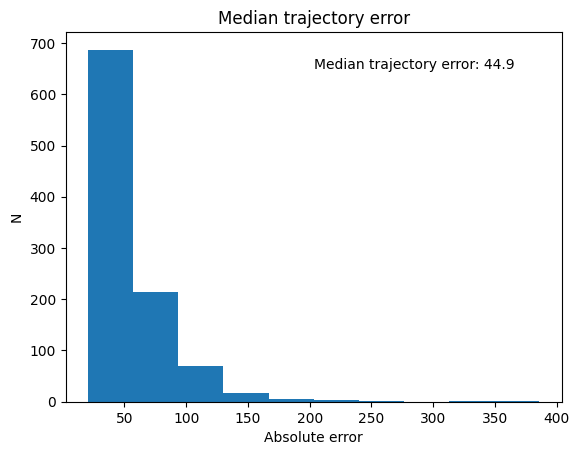

In [ ]:
error_traj_mod = error_traj[error_traj < 1e20]
print("Number of elements in error_traj: ", len(error_traj), "Number of elements in error_traj_mod: ", len(error_traj_mod))
error_tot_traj = round(np.median(error_traj_mod),3)
print("Mean trajectory error: ", error_tot_traj)

plt.hist(error_traj_mod, bins=10)
plt.xlabel('Absolute error')
plt.ylabel('N')
plt.text(0.5, 0.9, f"Median trajectory error: {error_tot_traj:.3}", transform=plt.gca().transAxes)
plt.title('Median trajectory error')
plt.show()


### Impact - BROKEN AHHHHHHHHHHHHHHHHHh i am going crazy

In [ ]:
X_resimulation_perm = X_resimulation.transpose(1, 0, 2, 3)
print(f'{X_resimulation_perm.shape=}')

X_resimulation_perm.shape=(1000, 100, 30, 3)


In [ ]:
impact_indices = [np.where(np.diff((X_resimulation_perm[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation_perm.shape[0])]

In [ ]:
mean_impact = np.zeros((len(impact_indices), 2))

for sim_num in range(len(impact_indices)):
    for i in range(len(impact_indices[sim_num][0])):
        mean_impact[sim_num, 0] += impact_indices[sim_num][0][i]
        mean_impact[sim_num, 1] += impact_indices[sim_num][1][i]

    mean_impact[sim_num, 0] /= len(impact_indices[sim_num][0])
    mean_impact[sim_num, 1] /= len(impact_indices[sim_num][1])

print(f'{mean_impact.shape=}')

mean_impact.shape=(1000, 2)


In [ ]:
X_trajectories[22][29]

array([ -0.79738716, -15.11917101,   3.29766588])

In [ ]:
def find_sign_change_idx(sample):
    for i in range(len(sample) - 1):
        if sample[i][2] > 0 and sample[i + 1][2] < 0:
            return i
        
    print("FUCK")
    return None

In [ ]:
coordinates = []

for sample in X_trajectories:
    idx = find_sign_change_idx(sample)
    if idx is not None:
        x, y, _ = sample[idx]  # Extracting x and y coordinates
        coordinates.append((x, y))

FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK


In [ ]:
print(f'{len(coordinates)=}')

len(coordinates)=21


In [ ]:
true_impact_indices = np.where(np.diff((X_trajectories[:, :, -1] > 0).astype(int)) == -1)
print(f'{len(true_impact_indices)=}')
print(f'{type(true_impact_indices[0])=}')
print(f'{true_impact_indices[0].shape=}')

len(true_impact_indices)=2
type(true_impact_indices[0])=<class 'numpy.ndarray'>
true_impact_indices[0].shape=(403,)


In [ ]:
X_val_impact_positions = X_trajectories[true_impact_indices[0], true_impact_indices[1]]
print(f'{X_val_impact_positions.shape=}')
print(f'{X_val_impact_positions[0].shape=}')

X_val_impact_positions.shape=(403, 3)
X_val_impact_positions[0].shape=(3,)
